# Find my Star - Testing

### Imports

In [79]:
import math
import cv2
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler

from scipy.spatial import KDTree
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon
from matplotlib import transforms
import matplotlib.image as mpimg

from skyfield.api import Star, load, wgs84, load_constellation_names
from skyfield.data import hipparcos, stellarium
from skyfield.projections import build_stereographic_projection


## Reference star coordinates found, reference map creation

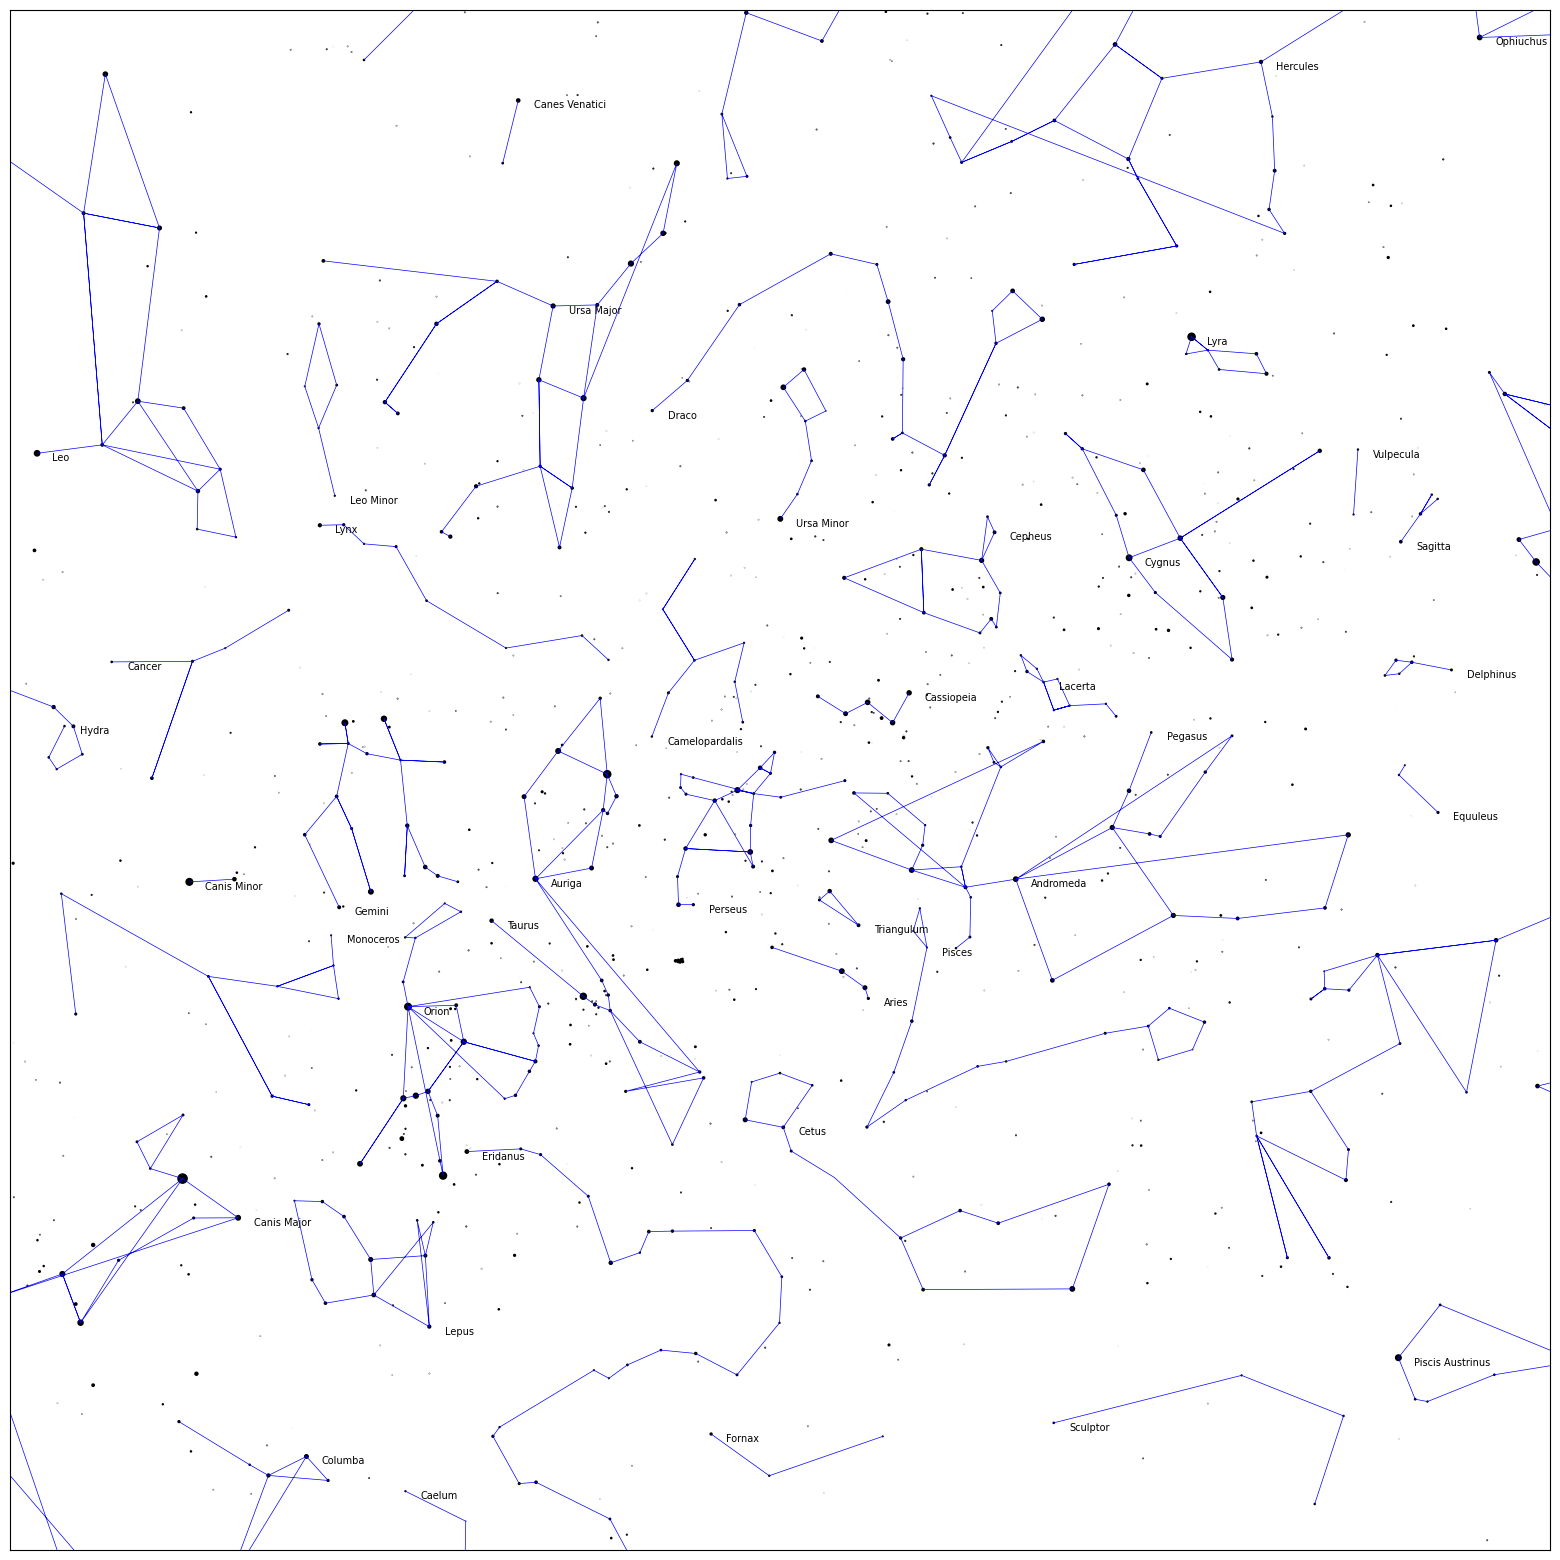

In [523]:
### PARAMS ###
t = load.timescale().utc(2024, 10, 11, 2)
observer = wgs84.latlon(latitude_degrees=51.9, longitude_degrees=-8.5).at(t)

eph = load('data/reference/de421.bsp')
sun = eph['sun']
earth = eph['earth']

with load.open('data/reference/hip_main.dat') as f:
    stars_df = hipparcos.load_dataframe(f)

up_pos = observer.from_altaz(alt_degrees=90, az_degrees=90)
up_ra, up_dec, _ = up_pos.radec()

zenith = Star(ra_hours=up_ra.hours, dec_degrees=up_dec.degrees)

center = earth.at(t).observe(zenith)
projection = build_stereographic_projection(center)
field_of_view_degrees = 180
mag_lim = 5.2

stars_star = Star.from_dataframe(stars_df)
star_positions = earth.at(t).observe(stars_star)
stars_in_view_df = stars_df.copy()
stars_in_view_df['x'], stars_in_view_df['y'] = projection(star_positions)

bright_stars = (stars_in_view_df.magnitude <= mag_lim)
magnitudes = stars_in_view_df['magnitude'][bright_stars]
img_marker_size = (mag_lim - magnitudes) ** 2
real_lum = (mag_lim - magnitudes) * 2

with load.open('data/reference/constellationship.fab') as f:
    constellations = stellarium.parse_constellations(f)

lines = []
centroids = []
for name, edges in constellations:
    const_lines = []
    for star in edges:
        x1 = stars_in_view_df['x'][star[0]]
        y1 = stars_in_view_df['y'][star[0]]
        x2 = stars_in_view_df['x'][star[1]]
        y2 = stars_in_view_df['y'][star[1]]
        const_lines.append((x1, y1))
        const_lines.append((x2, y2))
    centroids.append(const_lines[0])
    lines.append(const_lines)

const_dict = dict(load_constellation_names())
const_names = [const_dict[i] for i in np.array(constellations, dtype=object)[:, 0]]

fig, ax = plt.subplots(figsize=(20, 20))
ax.add_collection(LineCollection(lines, colors='b', linewidths=0.5))
ax.scatter(stars_in_view_df['x'][bright_stars], stars_in_view_df['y'][bright_stars], s=img_marker_size, color='k')
for i, name in enumerate(const_names):
    x = centroids[i][0] + 0.02
    y = centroids[i][1]
    ax.annotate(name, (x,y), horizontalalignment='left', verticalalignment='top', fontsize=7)
angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)
plt.show()
# plt.savefig(f'data/output/ref_chart.png', bbox_inches='tight')

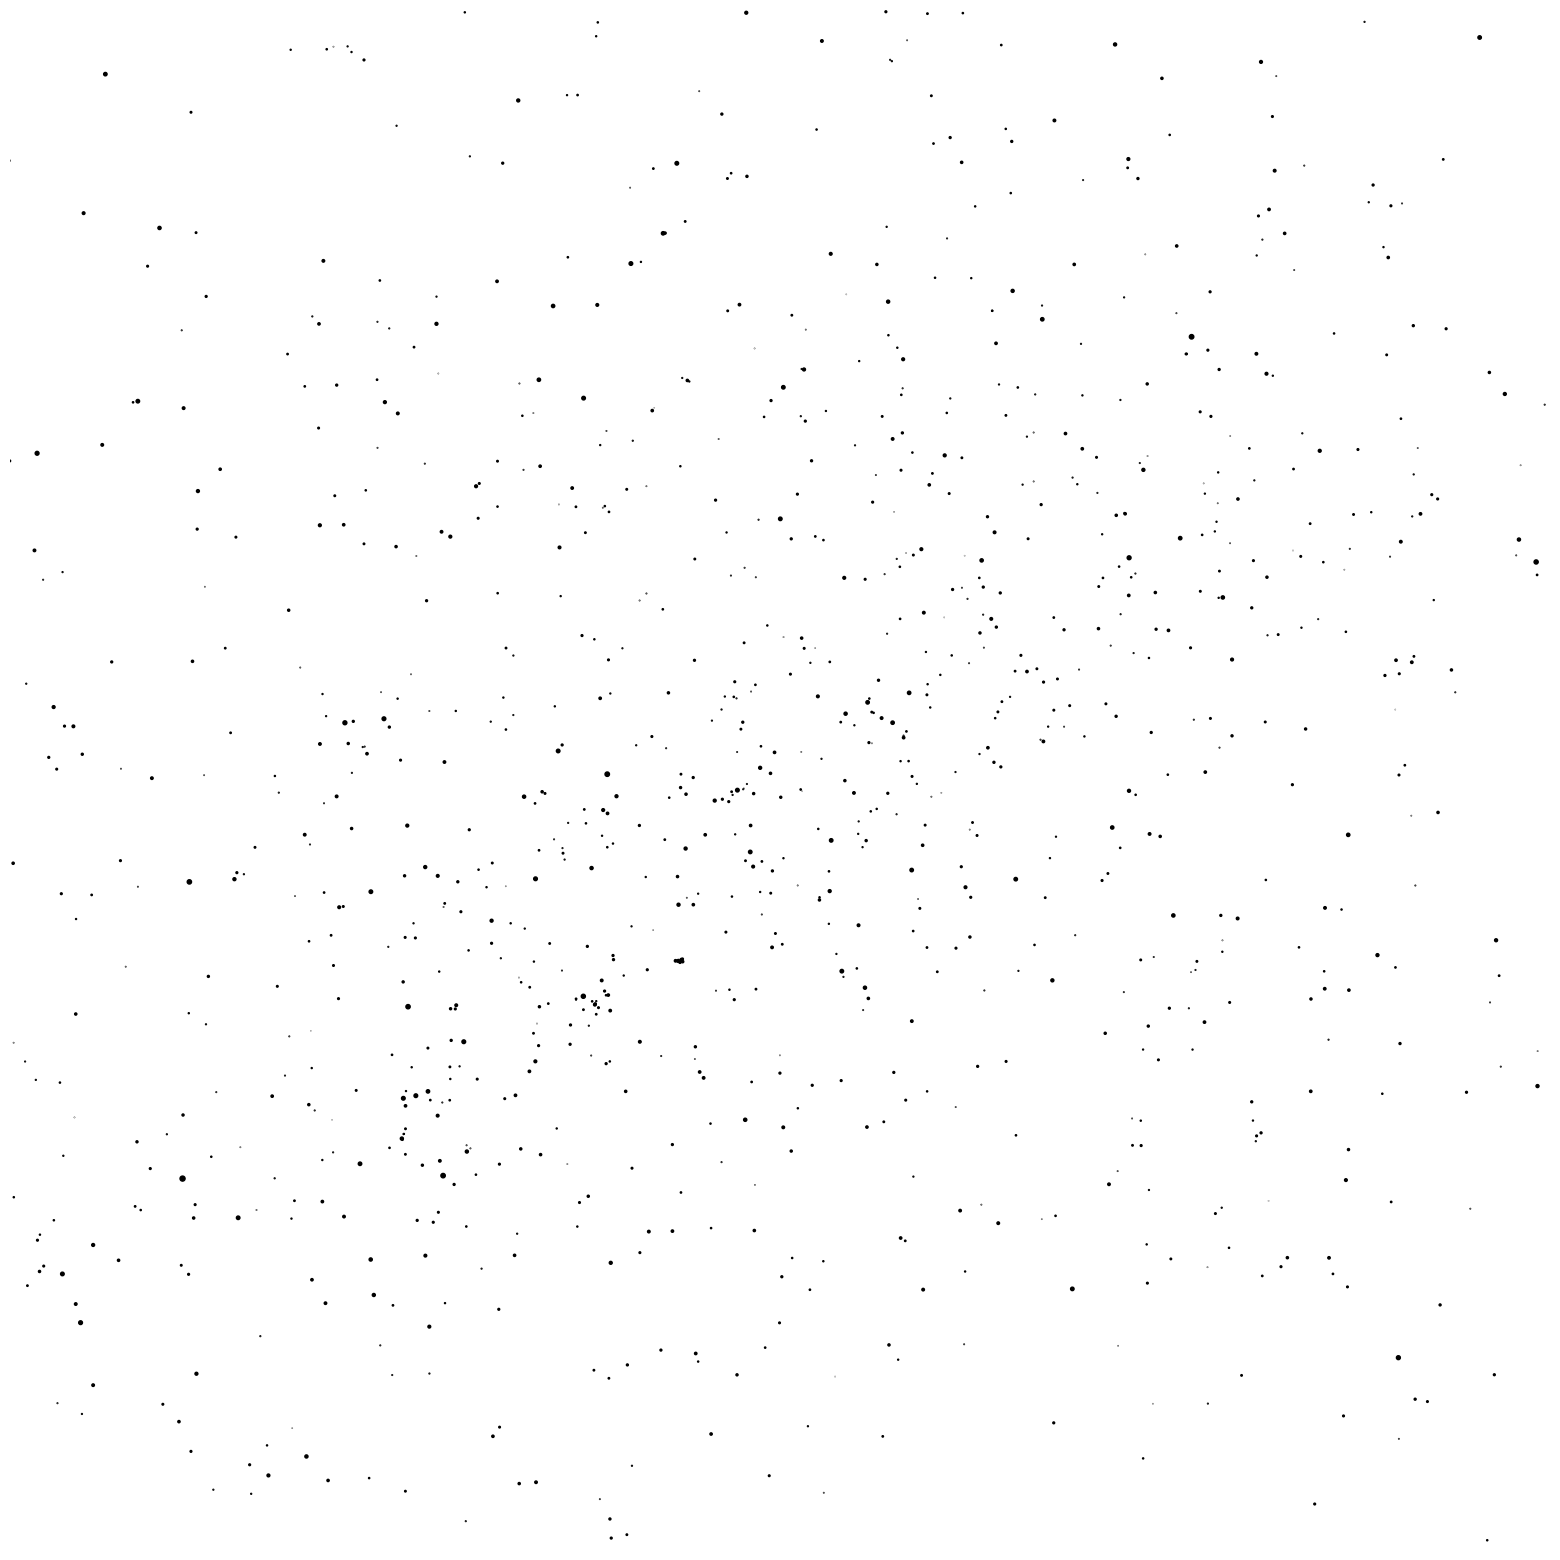

In [524]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(stars_in_view_df['x'][bright_stars], stars_in_view_df['y'][bright_stars], s=real_lum, color='k')
angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_aspect(1.0)
plt.show()
# plt.savefig(f'data/output/ref_img.png', bbox_inches='tight')

In [487]:
def viz_levels(image):
    cut_levels = pd.Series(image.flatten()).value_counts(bins=50).reset_index().set_axis(['value', 'count'], axis=1)
    cut_levels['value'] = [int(i.mid) for i in cut_levels['value']]
    cut_levels = cut_levels[cut_levels['value'] > 5]
    high_cut_levels = cut_levels[cut_levels['value'] > 100]

    fig = plt.figure(constrained_layout=True, figsize=(10,6))
    gs = fig.add_gridspec(3, 4)
    ax1 = fig.add_subplot(gs[:, 0:3])
    ax2 = fig.add_subplot(gs[1, 2:4])

    ax1.bar(cut_levels['value'], cut_levels['count'], width=4, color='royalblue')
    ax2.bar(high_cut_levels['value'], high_cut_levels['count'], width=4, color='darkblue')
    ax1.set_xticks([5, 55, 105, 155, 205, 255])
    ax1.set_xlim([5, 255])
    plt.show()
    return

def light_percent(image):
    all_coords = np.column_stack(np.where(image >= 0))
    grey_coords = np.column_stack(np.where(image > 0))
    print(f"the image is {np.round(grey_coords.size/all_coords.size*100, 2)}% light")

the image is 0.54% light


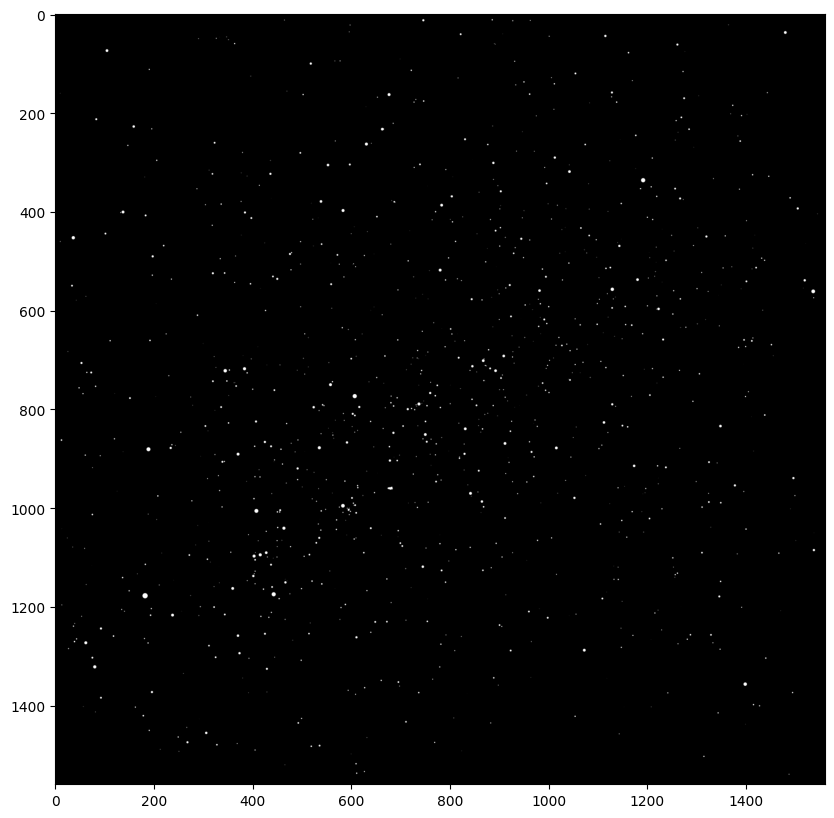

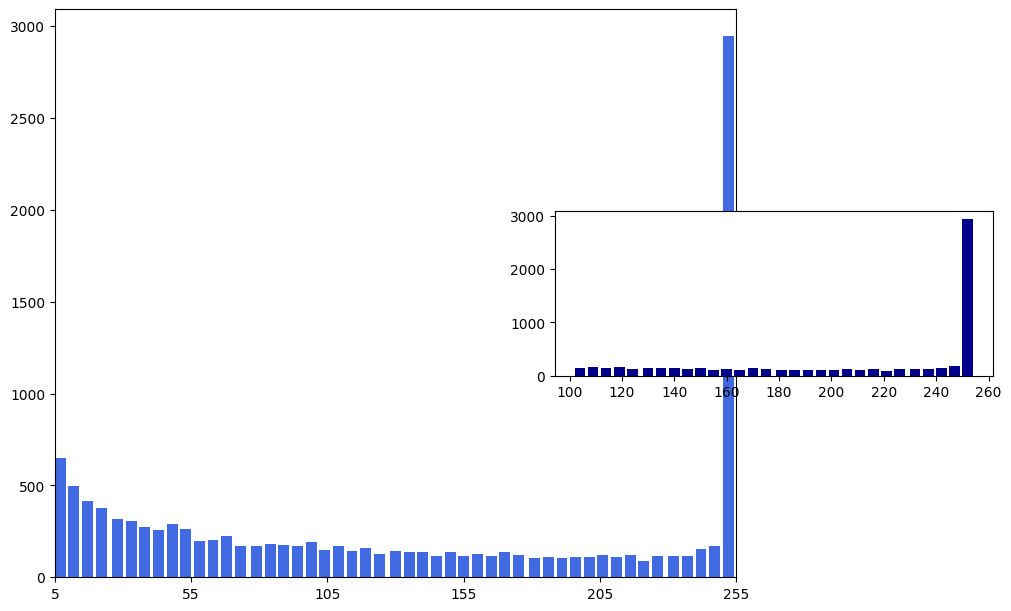

In [488]:
ref_img = "data/output/ref_img.png"
ref_img = cv2.imread(ref_img, flags=cv2.IMREAD_GRAYSCALE)
ref_img = cv2.bitwise_not(ref_img)

plt.subplots(figsize=(10,10))
plt.imshow(ref_img, cmap="gray")

light_percent(ref_img)

viz_levels(ref_img)

## Test Image import and processing

the image is 100.0% light


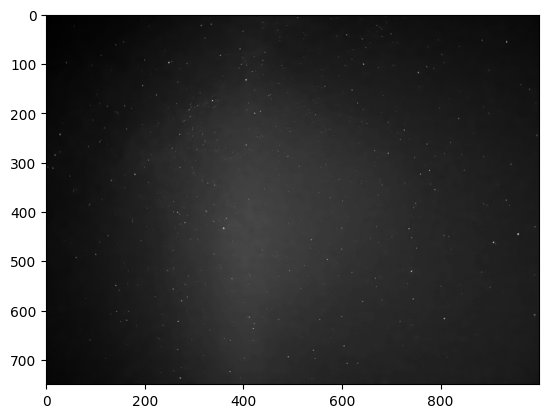

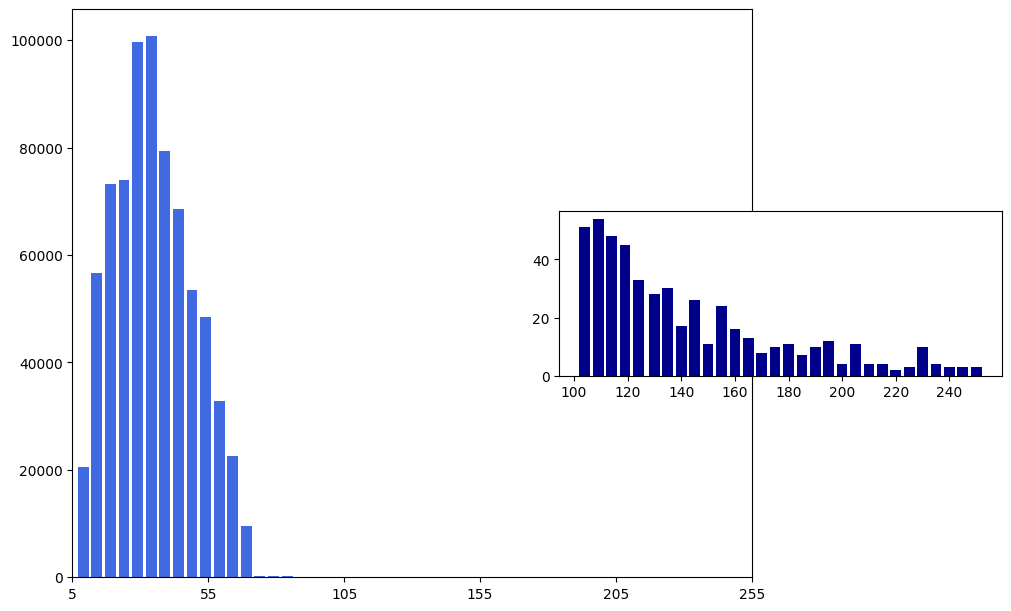

In [529]:
# import test image no. 1
test_img = "data/testing/astro1.jpeg"
test_grey = cv2.imread(test_img, flags=cv2.IMREAD_GRAYSCALE)
max_len = max(test_grey.shape)
scale_ratio = 1000 / max_len
x_scaled = int(test_grey.shape[1]*scale_ratio)
y_scaled = int(test_grey.shape[0]*scale_ratio)
test_grey = cv2.resize(test_grey, dsize=(x_scaled, y_scaled), interpolation=cv2.INTER_AREA)

light_percent(test_grey)

plt.imshow(test_grey, cmap="grey")

viz_levels(test_grey)

the image is 0.02% light


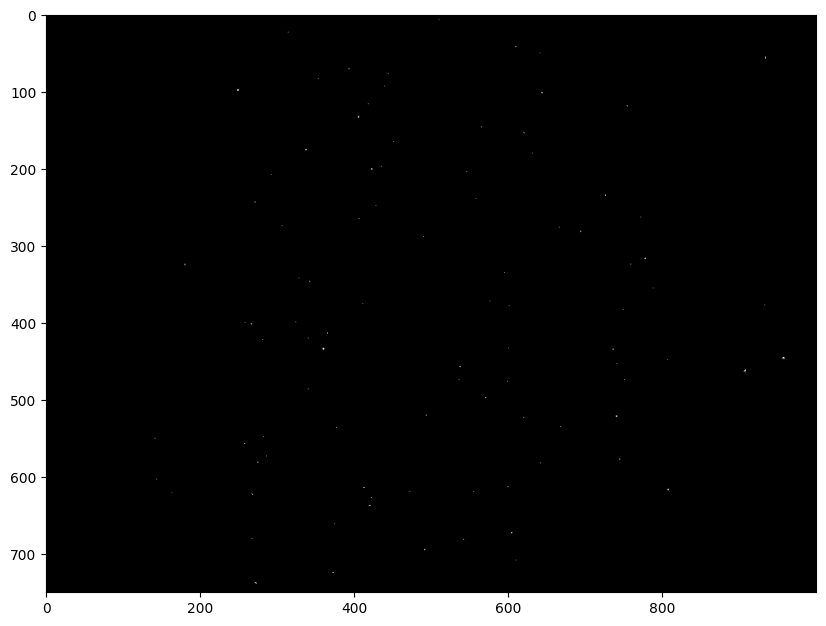

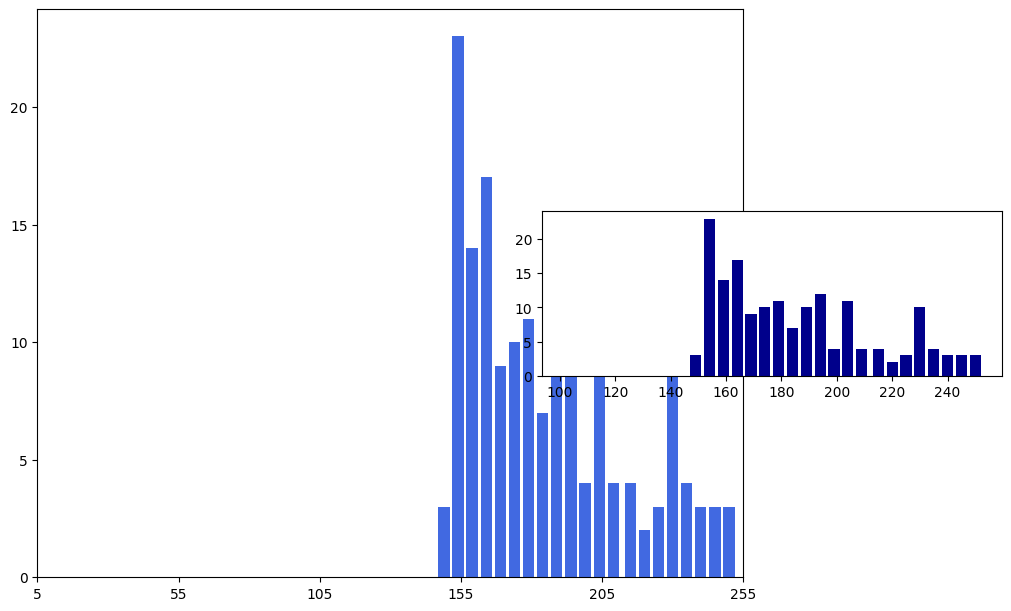

In [556]:
# remove all data below cutoff and visualize
hard_cut_test = test_grey.copy()
hard_cut_test[hard_cut_test<150] = 0
light_percent(hard_cut_test)
plt.subplots(figsize=(10,7.5))
plt.imshow(hard_cut_test, cmap="grey")
viz_levels(hard_cut_test)

## Image Transformation - getting centroids of objects

In [557]:
# transform to binary map
_, test_bi = cv2.threshold(hard_cut_test, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
test_bi.shape

(750, 1000)

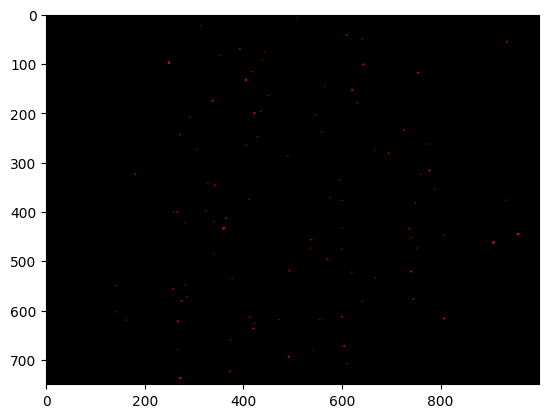

In [558]:
test_color = cv2.cvtColor(hard_cut_test, cv2.COLOR_GRAY2RGB)
test_cont, _ = cv2.findContours(test_bi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(test_color, test_cont, -1, (255,0,0), 2)
plt.subplots()
plt.imshow(test_color)
plt.show()


In [559]:

def get_centroids(contours):
    centroids = []

    for cont in contours:
        xs = cont[:, :, 0].flatten()
        ys = cont[:, :, 1].flatten()

        xroll = np.roll(xs,1)
        yroll = np.roll(ys,1)
        poly_area = np.abs(np.dot(xs, yroll) - np.dot(ys, xroll))/2
        if poly_area == 0:
            cx = np.round(np.mean(xs), 2)
            cy = np.round(np.mean(ys), 2)
        else:
            cx = np.round(np.sum((xs + xroll) * (xs * yroll - xroll * ys))/(6 * poly_area), 2)
            cy = np.round(np.sum((ys + yroll) * (xs * yroll - xroll * ys))/(6 * poly_area), 2)

        centroids.append((cx, cy))

    return centroids

reference centroids: 95


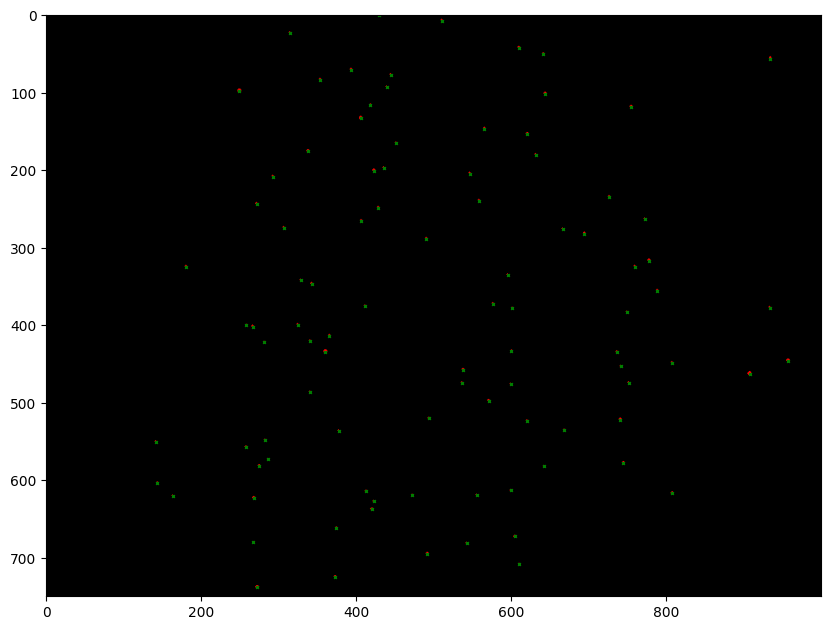

In [560]:
test_centroids = get_centroids(test_cont)
print(f'reference centroids: {len(test_centroids)}')

x_cent = [cent[0] for cent in test_centroids]
y_cent = [cent[1] for cent in test_centroids]

plt.subplots(figsize=(10,10))
plt.imshow(test_color)
plt.plot(x_cent, y_cent, 'xg', markersize=2)
plt.show()

## Triangulate stars & get angles

In [561]:
# from the center point, find the 3 closest points that, when connected, form a triangle around the center point

def area(X, Y, n):
    area = 0.0
    j = n - 1
    for i in range(0,n):
        area += (X[j] + X[i]) * (Y[j] - Y[i])
        j = i

    return abs(area / 2.0)

def get_triangles(center, ABC):
    PAB = [center, ABC[0], ABC[1]]
    PBC = [center, ABC[1], ABC[2]]
    PAC = [center, ABC[0], ABC[2]]

    return ABC, [PAB, PBC, PAC]

def get_coords(triangle):
    X = [x[0] for x in triangle]
    Y = [x[1] for x in triangle]
    return X, Y

def check_areas(center_star, outer_stars):
    if len(outer_stars) > 3:
        poss_triangles = list(combinations(outer_stars, 3))
    else:
        poss_triangles = [outer_stars]

    for triangle in poss_triangles:
        outer_tri, inner_tris = get_triangles(center_star, triangle)
        outer_area = area(*get_coords(outer_tri), 3)

        inner_area = 0
        for tri in inner_tris:
            inner_area += area(*get_coords(tri), 3)

        if abs(outer_area - inner_area) < 1e-9:
            return triangle


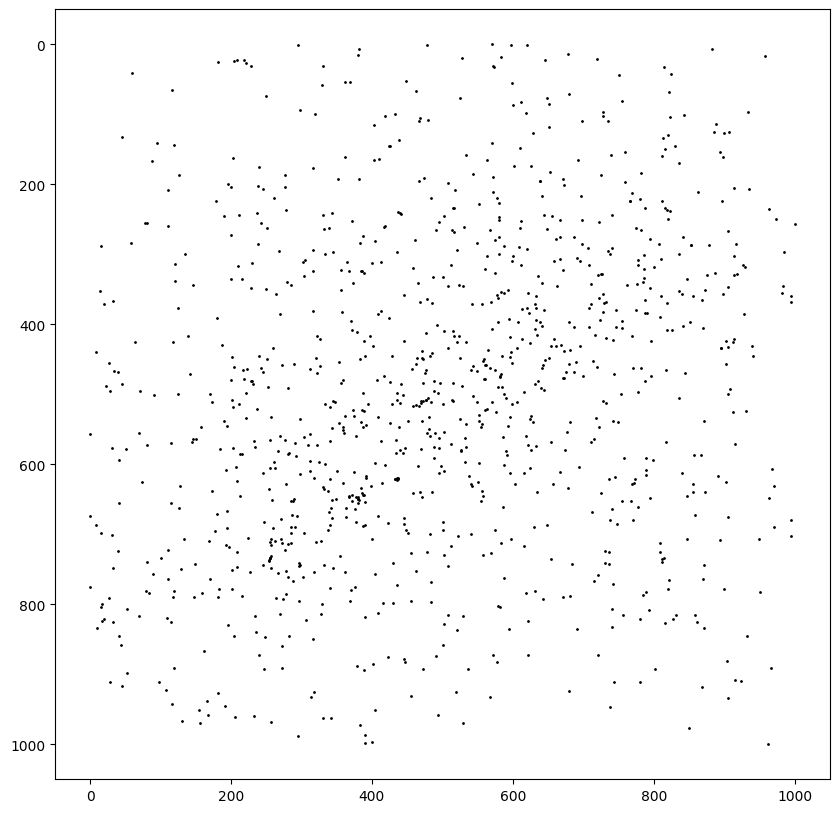

In [562]:
slim_star_df = stars_in_view_df[bright_stars]
slim_star_df = slim_star_df[(slim_star_df['x'] < limit ) & (slim_star_df['x'] > -limit) &
                            (slim_star_df['y'] < limit) & (slim_star_df['y'] > -limit)]
ref_coords = slim_star_df.loc[:, ('x', 'y')]

scaler = MinMaxScaler((0, 1000))
ref_centroids = scaler.fit_transform(ref_coords)
ref_centroids = np.array([(x, 1000-y) for x, y in ref_centroids])

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(ref_centroids[:, 0], ref_centroids[:, 1], s=1, color='k')
plt.gca().invert_yaxis()
plt.show()

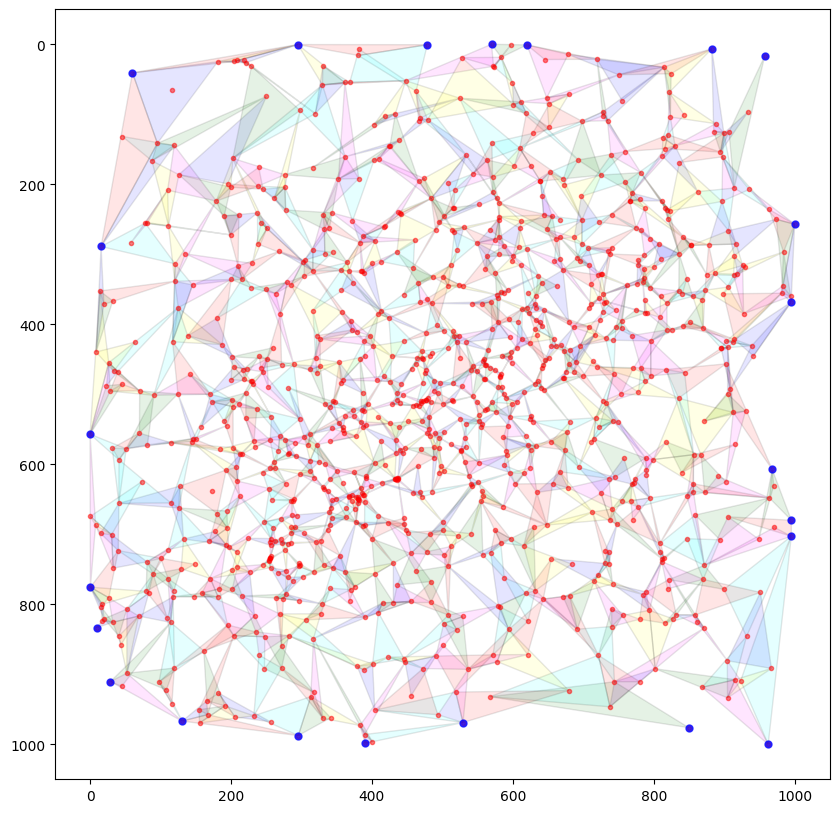

In [563]:
ref_tree = KDTree(ref_centroids, )

triangles = []
central_stars = []
loners = []
for star in ref_centroids:
    _, center_idx = ref_tree.query(star, k=1)
    center_star = ref_centroids[center_idx]

    _, central_idxs = ref_tree.query(star, k=25)
    outer_stars = [ref_centroids[i] for i in central_idxs[1:]]

    emcomp_tri = check_areas(center_star, outer_stars)
    if emcomp_tri:
        triangles.append(emcomp_tri)
        central_stars.append(star)
    else:
        loners.append(star)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ref_centroids[:, 0], ref_centroids[:, 1], 'or', markersize=3, alpha=0.5)
ax.plot([x[0] for x in loners], [x[1] for x in loners], 'ob', markersize=5, alpha=0.75)
colors = ['red', 'green', 'blue', 'magenta', 'yellow', 'cyan']
c = 0
for tri in triangles:
    ax.add_patch(Polygon(tri, alpha=0.1, edgecolor='black', facecolor=colors[c], linewidth=1))
    if c < len(colors) - 1:
        c += 1
    else:
        c = 0
plt.gca().invert_yaxis()
plt.show()

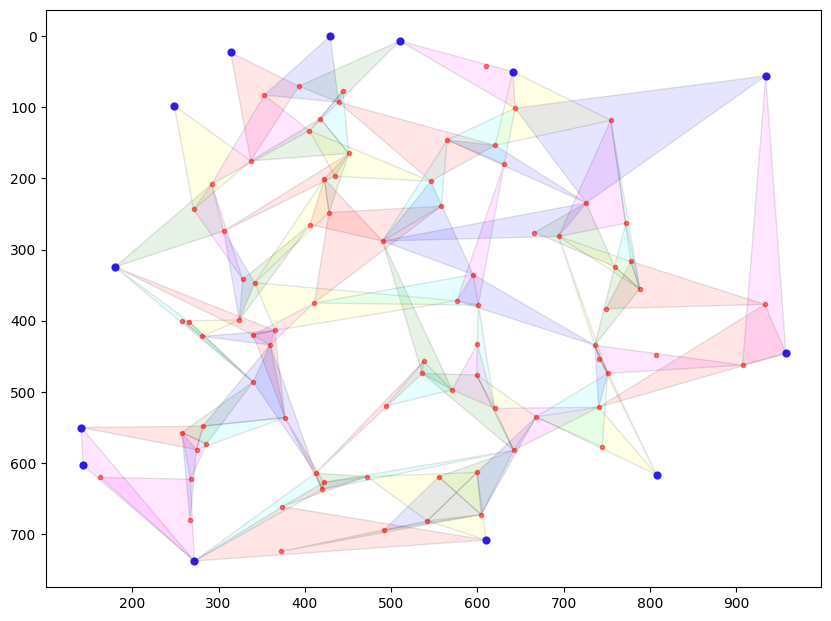

In [564]:
test_tree = KDTree(test_centroids, )

test_triangles = []
test_central_stars = []
test_loners = []
for star in test_centroids:
    _, center_idx = test_tree.query(star, k=1)
    center_star = test_centroids[center_idx]

    _, central_idxs = test_tree.query(star, k=25)
    outer_stars = [test_centroids[i] for i in central_idxs[1:]]

    emcomp_tri = check_areas(center_star, outer_stars)
    if emcomp_tri:
        test_triangles.append(emcomp_tri)
        test_central_stars.append(star)
    else:
        test_loners.append(star)

test_centroids = np.array(test_centroids)
fig, ax = plt.subplots(figsize=(10,7.5))
ax.plot(test_centroids[:, 0], test_centroids[:, 1], 'or', markersize=3, alpha=0.5)
ax.plot([x[0] for x in test_loners], [x[1] for x in test_loners], 'ob', markersize=5, alpha=0.75)
colors = ['red', 'green', 'blue', 'magenta', 'yellow', 'cyan']
c = 0
for tri in test_triangles:
    ax.add_patch(Polygon(tri, alpha=0.1, edgecolor='black', facecolor=colors[c], linewidth=1))
    if c < len(colors) - 1:
        c += 1
    else:
        c = 0
plt.gca().invert_yaxis()
plt.show()

## Matching

In [565]:
# d = sqrt [(x2 - x1)^2 + (y2 - y1)^2]
# theta = arccos((a^2 + b^2 - c^2) / 2ab)

In [566]:
def area(X, Y, n):
    area = 0.0
    j = n - 1
    for i in range(0,n):
        area += (X[j] + X[i]) * (Y[j] - Y[i])
        j = i

    return abs(area / 2.0)


def get_triangles(center, ABC):
    PAB = [center, ABC[0], ABC[1]]
    PBC = [center, ABC[1], ABC[2]]
    PAC = [center, ABC[0], ABC[2]]

    return ABC, [PAB, PBC, PAC]


def get_coords(triangle):
    X = [x[0] for x in triangle]
    Y = [x[1] for x in triangle]

    return X, Y


def check_areas(center_star, outer_stars):
    if len(outer_stars) > 3:
        poss_triangles = list(combinations(outer_stars, 3))
    else:
        poss_triangles = [outer_stars]

    for triangle in poss_triangles:
        outer_tri, inner_tris = get_triangles(center_star, triangle)
        outer_area = area(*get_coords(outer_tri), 3)

        inner_area = 0
        for tri in inner_tris:
            inner_area += area(*get_coords(tri), 3)

        if abs(outer_area - inner_area) < 1e-9:
            return triangle


def get_distance(p1, p2):
	return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


def get_triangulators(centroids):
    star_tree = KDTree(centroids, )
    triangles = []
    central_stars = []
    for centroid in centroids:
        _, central_idxs = star_tree.query(centroid, k=50)
        center_star = centroids[central_idxs[0]]
        outer_stars = [centroids[i] for i in central_idxs[1:]]

        emcomp_tri = check_areas(center_star, outer_stars)
        if emcomp_tri:
            triangles.append(emcomp_tri)
            central_stars.append(centroid)

    return triangles, central_stars



def get_angles(triangles, central_stars):
    angles = []
    for i in range(len(triangles)):
        A, B, C = triangles[i]
        P = central_stars[i]

        AP = get_distance(A, P)
        BP = get_distance(B, P)
        CP = get_distance(C, P)
        AB = get_distance(A, B)
        BC = get_distance(B, C)
        AC = get_distance(A, C)

        angle1 = math.acos((AP**2 + BP**2 - AB**2) / (2 * AP * BP)) * 180 / math.pi
        angle2 = math.acos((BP**2 + CP**2 - BC**2) / (2 * BP * CP)) * 180 / math.pi
        angle3 = math.acos((CP**2 + AP**2 - AC**2) / (2 * CP * AP)) * 180 / math.pi

        inner = sorted([angle1, angle2, angle3])

        angle4 = math.acos((AB**2 + AP**2 - BP**2) / (2 * AB * AP)) * 180 / math.pi
        try:
            angle5 = math.acos((AB**2 + BP**2 - AP**2) / (2 * AB * BP)) * 180 / math.pi
        except ValueError:
            angle5 = 0
        angle6 = math.acos((BC**2 + BP**2 - CP**2) / (2 * BC * BP)) * 180 / math.pi
        angle7 = math.acos((BC**2 + CP**2 - BP**2) / (2 * BC * CP)) * 180 / math.pi
        angle8 = math.acos((AC**2 + AP**2 - CP**2) / (2 * AC * AP)) * 180 / math.pi
        angle9 = math.acos((AC**2 + CP**2 - AP**2) / (2 * AC * CP)) * 180 / math.pi

        outer = sorted([angle4, angle5, angle6, angle7, angle8, angle9])

        angles.append(inner + outer)

    return angles

In [567]:
ref_tris, ref_stars = get_triangulators(ref_centroids)
ref_angles = get_angles(ref_tris, ref_stars)

In [568]:
test_tris, test_stars = get_triangulators(test_centroids)
test_angles = get_angles(test_tris, test_stars)


In [569]:
# compare ref and test angles and find closest match

# scale = ref_dist / test_dist
# rotation_angle = ref_angle - test_angle

def scale_point(point, ref_point, scale_factor):
    return (
        ref_point[0] + scale_factor * (point[0] - ref_point[0]),
        ref_point[1] + scale_factor * (point[1] - ref_point[1])
    )

def rotate_point(point, ref_point, angle):
    cos_theta = math.cos(angle)
    sin_theta = math.sin(angle)
    # Translate point to origin, apply rotation, then translate back
    translated_x = point[0] - ref_point[0]
    translated_y = point[1] - ref_point[1]
    rotated_x = translated_x * cos_theta - translated_y * sin_theta
    rotated_y = translated_x * sin_theta + translated_y * cos_theta
    return (rotated_x + ref_point[0], rotated_y + ref_point[1])


### stop this stuff and just make a flipped image with it's own tree
def reflect_point(x, y, a, b, c):
    d = (a * x + b * y + c) / (a**2 + b**2)
    x_reflected = x - 2 * a * d
    y_reflected = y - 2 * b * d
    return x_reflected, y_reflected

def reflect(central_star, tri):

    A, B, C = tri

    P1, P2 = A, B

    a = P1[1] - P2[1]  # y1 - y2
    b = P2[0] - P1[0]  # x2 - x1
    c = P1[0] * P2[1] - P2[0] * P1[1]  # x1*y2 - x2*y1

    A_reflected = reflect_point(A[0], A[1], a, b, c)
    B_reflected = reflect_point(B[0], B[1], a, b, c)
    C_reflected = reflect_point(C[0], C[1], a, b, c)
    central_ref = reflect_point(central_star[0], central_star[1], a, b, c)
    tri_ref = np.array([A_reflected, B_reflected, C_reflected])

    return central_ref, tri_ref

def get_ratios(ref_star, ref_tri, test_id, match_diffs, match_factors,
               better_matches, match, ratio_lim, diff_lim, verbose):

    d1 = get_distance(ref_star, ref_tri[0])
    d2 = get_distance(ref_star, ref_tri[1])
    d3 = get_distance(ref_star, ref_tri[2])
    ref_dists = sorted([d1, d2, d3])

    test_star = test_stars[test_id]
    test_tri = np.array(test_tris[test_id])
    d4 = get_distance(test_star, test_tri[0])
    d5 = get_distance(test_star, test_tri[1])
    d6 = get_distance(test_star, test_tri[2])
    test_dists = sorted([d4, d5, d6])
    ratio1 = ref_dists[0] / test_dists[0]
    ratio2 = ref_dists[1] / test_dists[1]
    ratio3 = ref_dists[2] / test_dists[2]

    ratio_diff = round(abs(ratio1 - ratio2) + abs(ratio1 - ratio3) + abs(ratio2 - ratio3), 2)

    ref_angle = math.atan2(ref_tri[0][1] - ref_star[1], ref_tri[0][0] - ref_star[0])
    test_angle = math.atan2(test_tri[0][1] - test_star[1], test_tri[0][0] - test_star[0])
    rotation_angle = ref_angle - test_angle
    scale_factor = (ratio1 + ratio2 + ratio3) / 3

    scaled_test_star = scale_point(test_star, ref_star, scale_factor)
    rotated_test_star = rotate_point(scaled_test_star, ref_star, rotation_angle)
    translation_vector = (ref_star[0] - rotated_test_star[0], ref_star[1] - rotated_test_star[1])
    aligned_test_star = (rotated_test_star[0] + translation_vector[0], rotated_test_star[1] + translation_vector[1])

    scaled_test_tri = [scale_point(pt, ref_star, scale_factor) for pt in test_tri]
    rotated_test_tri = [rotate_point(pt, ref_star, rotation_angle) for pt in scaled_test_tri]
    aligned_test_tri = np.array([(pt[0] + translation_vector[0],
                                    pt[1] + translation_vector[1]) for pt in rotated_test_tri])

    location_diff = sum(abs(ref_tri[0] - aligned_test_tri[0]) +
                        abs(ref_tri[1] - aligned_test_tri[1]) +
                        abs(ref_tri[2] - aligned_test_tri[2])) / (sum(ref_dists) / 3)

    match_diff = [ratio_diff, location_diff]
    match_factor = [round(scale_factor, 4), round(rotation_angle, 4)]

    if ratio_diff < ratio_lim:
        if location_diff < diff_lim:

            match_diffs.append(match_diff)
            match_factors.append(match_factor)
            better_matches.append(match)

            if verbose:
                print(ratio_diff, ' ', location_diff)
                fig, ax = plt.subplots(figsize=(3,3))
                ax.plot(ref_star[0], ref_star[1], marker="o", color='r', markersize=7, alpha=0.5)
                ax.plot(ref_tri[:, 0], ref_tri[:, 1], marker="*", color='r', markersize=7, alpha=0.5)
                ax.plot(aligned_test_star[0], aligned_test_star[1], marker="x", color='c', markersize=7, alpha=0.75)
                ax.plot(aligned_test_tri[:, 0], aligned_test_tri[:, 1], marker="*", color='c', markersize=7, alpha=0.5)
                min_x = min(*ref_tri[:, 0], *aligned_test_tri[:, 0])
                max_x = max(*ref_tri[:, 0], *aligned_test_tri[:, 0])
                min_y = min(*ref_tri[:, 1], *aligned_test_tri[:, 1])
                max_y = max(*ref_tri[:, 1], *aligned_test_tri[:, 1])
                ax.set_xlim([min_x - 10, max_x + 10])
                ax.set_ylim([min_y - 10, max_y + 10])
                plt.show()

    return


def find_matches(matches, ratio_lim=0.1, diff_lim=20, flip=False, verbose=False):
    match_diffs = []
    match_factors = []
    better_matches = []
    for match in matches:
        ref_star = ref_stars[match[0]]
        ref_tri = np.array(ref_tris[match[0]])
        test_id = match[1]
        if flip:
            ref_flip, ref_tri_flip = reflect(ref_star, ref_tri)
            get_ratios(ref_flip, ref_tri_flip, test_id, match_diffs, match_factors,
                       better_matches, match, ratio_lim, diff_lim, verbose)
        else:
            get_ratios(ref_star, ref_tri, test_id, match_diffs, match_factors,
                       better_matches, match, ratio_lim, diff_lim, verbose)

    return np.array(match_diffs), np.array(match_factors), np.array(better_matches)


In [580]:
### SET PARAMS HERE ###
max_dist = 5
ratio_lim = 0.5
diff_lim = 0.5
verbose = False

ref_tree = KDTree(ref_angles)

matches = []
dists = []
for t, test_set in enumerate(test_angles):
    dist, r = ref_tree.query(test_set, k=1)
    if dist < max_dist:
        matches.append([r, t])
        dists.append(dist)

match_diffs, match_factors, better_matches = \
    find_matches(matches, ratio_lim=ratio_lim, diff_lim=diff_lim, flip=False, verbose=verbose)
flipped_match_diffs, flipped_match_factors, flipped_better_matches = \
    find_matches(matches, ratio_lim=ratio_lim, diff_lim=diff_lim, flip=True, verbose=verbose)

avg_ldiff = sum(match_diffs[:, 0])/len(match_diffs)
avg_rdiff = sum(match_diffs[:, 1])/len(match_diffs)
avg_flipped_ldiff = sum(flipped_match_diffs[:, 0])/len(flipped_match_diffs)
avg_flipped_rdiff = sum(flipped_match_diffs[:, 1])/len(flipped_match_diffs)
avg_error = avg_ldiff * avg_rdiff
flip_avg_error = avg_flipped_ldiff * avg_flipped_rdiff
print(f'reg matches: {len(match_diffs)}, flipped matches: {len(flipped_match_diffs)}')
print(f'avg error: {avg_error}, flipped avg error: {flip_avg_error}')


reg matches: 10, flipped matches: 4
avg error: 0.011323784329601757, flipped avg error: 0.036951860162203344


modal avg scale factor: 0.54, 
modal avg rotation angle: -3.31


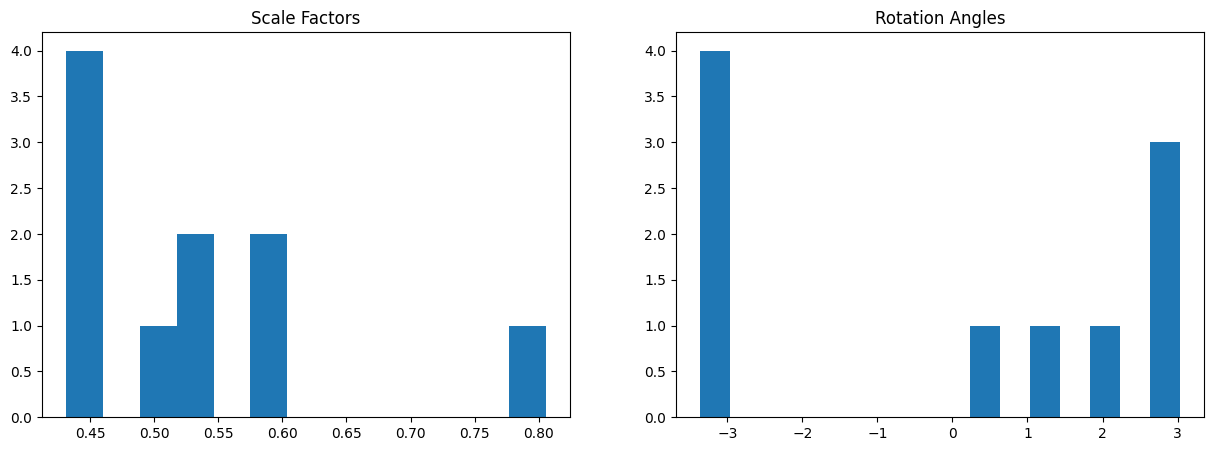

modal avg scale factor: 0.45, 
modal avg rotation angle: -3.65


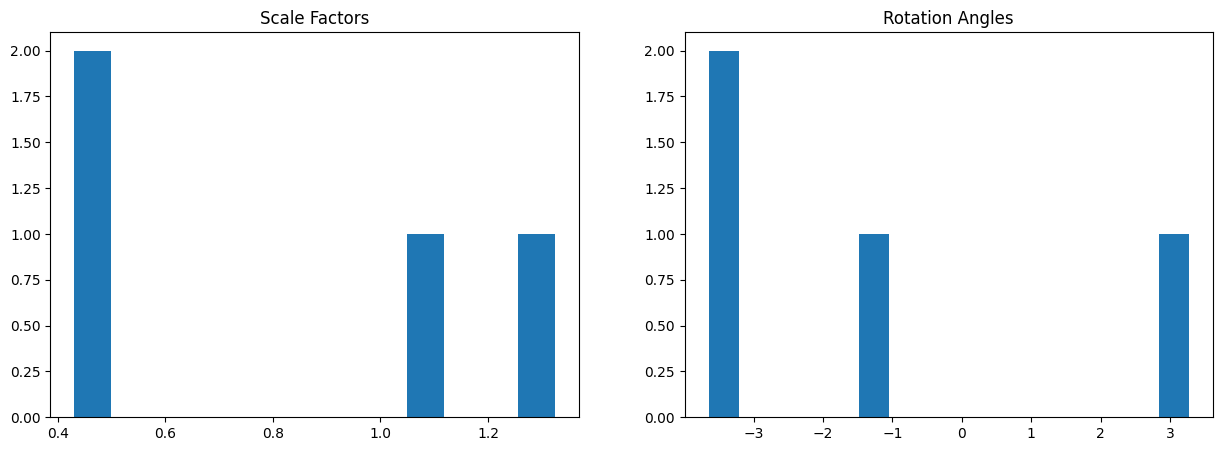

In [581]:
def show_dists(factors):
    round_sf = np.round(factors[:, 0], 1)
    rount_ra = np.round(factors[:, 1], 1)
    sf_mode = stats.mode(round_sf)[0]
    ra_mode = stats.mode(rount_ra)[0]

    sf_lb = sf_mode - 0.5
    sf_ub = sf_mode + 0.5
    ra_lb = ra_mode - 0.5
    ra_ub = ra_mode + 0.5

    factors_filt = np.array([factor for factor in factors if
                            (factor[0] >= sf_lb) & (factor[0] <= sf_ub) &
                            (factor[1] >= ra_lb) & (factor[1] <= ra_ub)])

    try:
        filt_avg_sf, filt_avg_ra = np.round(np.average(factors_filt, axis=0), 2)
        print(f'modal avg scale factor: {filt_avg_sf}, \nmodal avg rotation angle: {filt_avg_ra}')
    except TypeError:
        pass

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].hist(factors[:, 0], bins=13)
    ax[1].hist(factors[:, 1], bins=16)
    ax[0].set_title("Scale Factors")
    ax[1].set_title("Rotation Angles")
    plt.show()

show_dists(match_factors)
show_dists(flipped_match_factors)

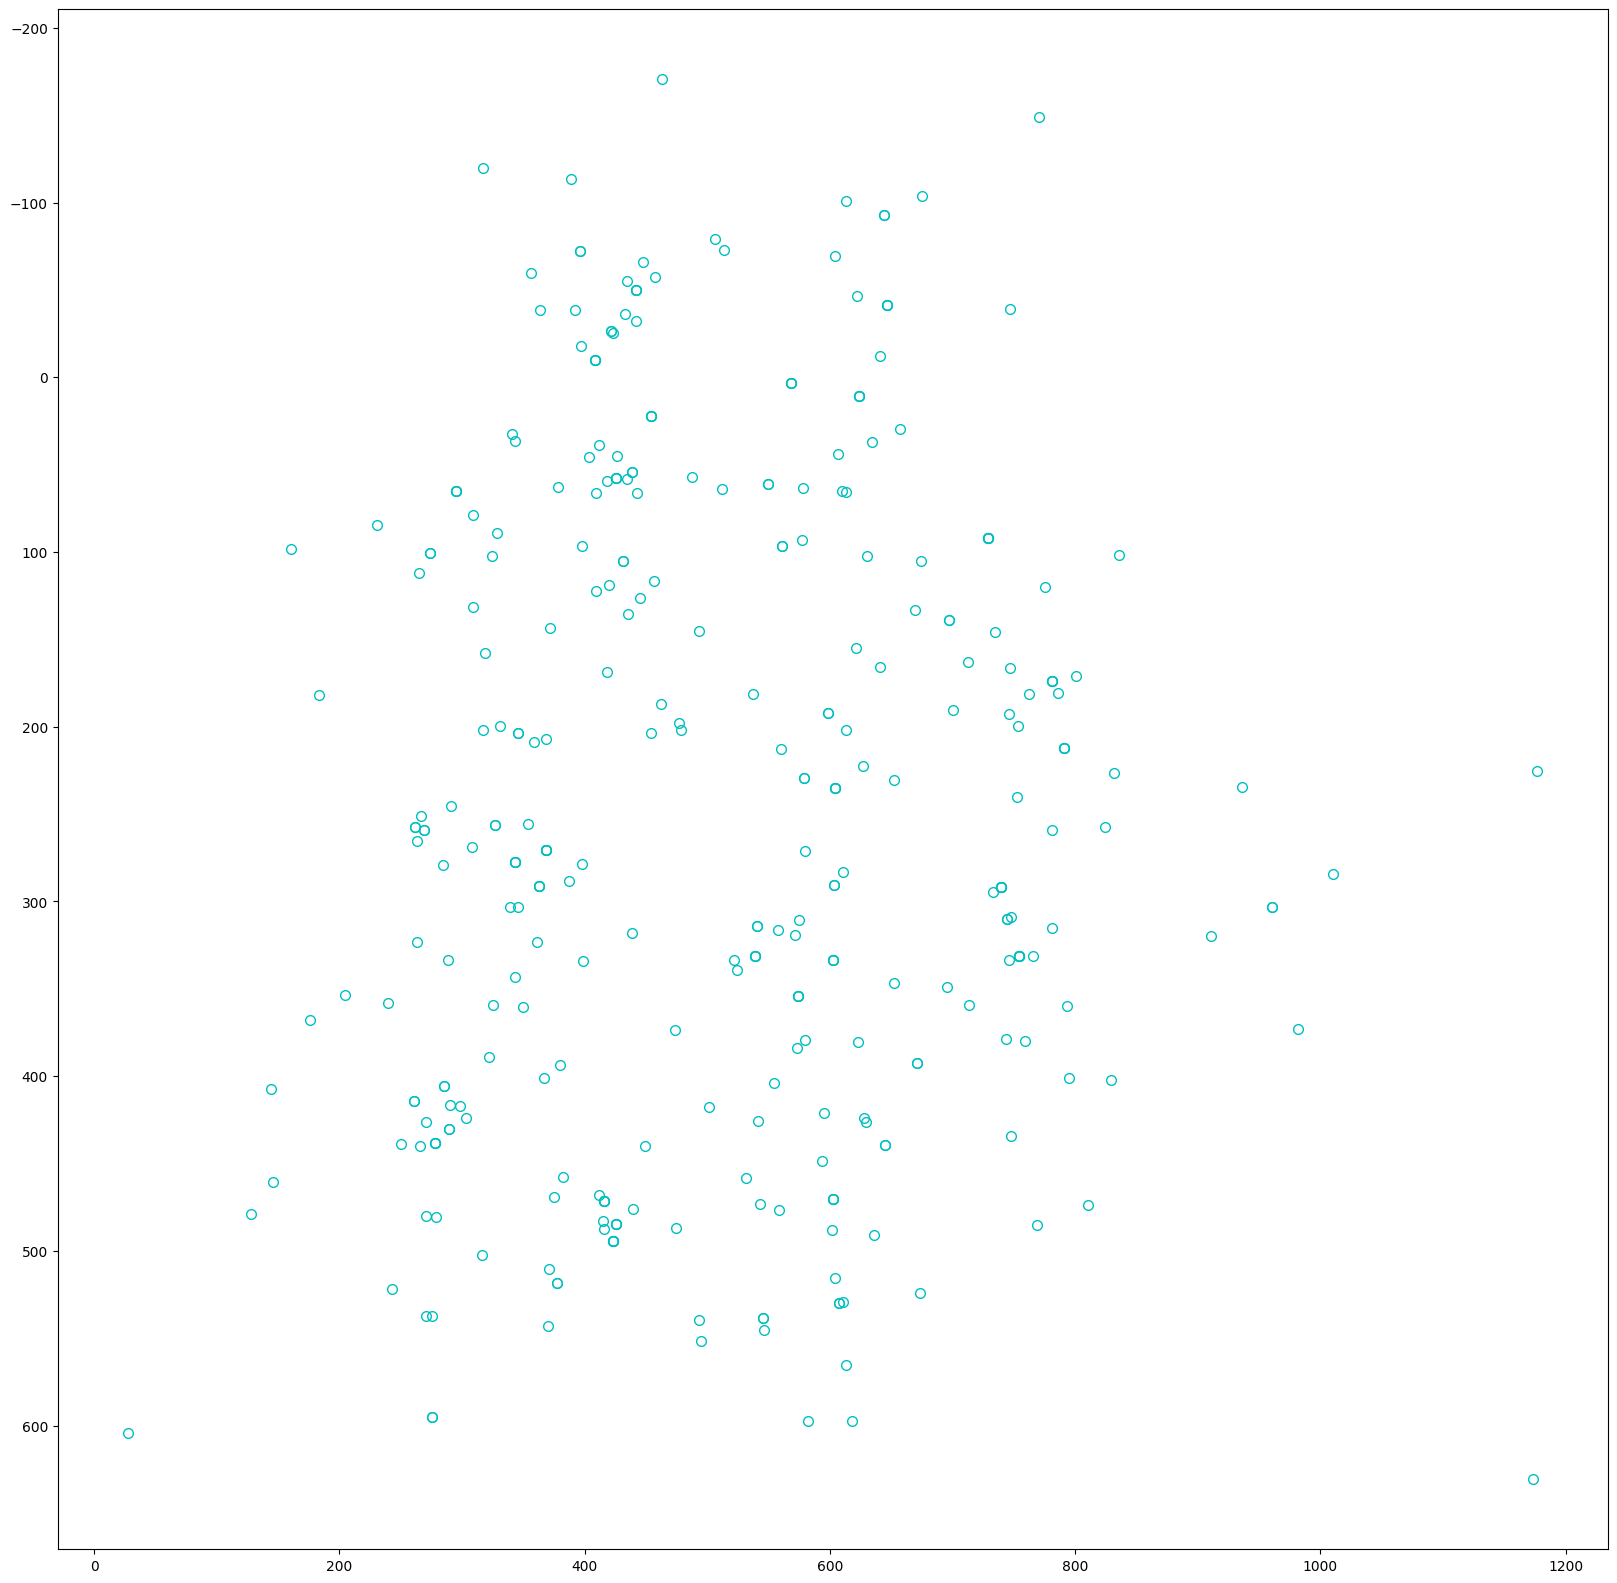

In [ ]:
### MESS WITH THESE ###
final_scale_factor = 1
final_roatation_angle = 0
flip = True


## WRONG
## scale = ref_dist / test_dist
## rotation_angle = ref_angle - test_angle


# def scale_rotate(point, scale_factor, angle):
#     cos_theta = math.cos(angle)
#     sin_theta = math.sin(angle)
#     scaled_x = scale_factor * point[0]
#     scaled_y = scale_factor * point[1]
#     rotated_x = scaled_x * cos_theta - scaled_y * sin_theta
#     rotated_y = scaled_x * sin_theta + scaled_y * cos_theta
#     return rotated_x, rotated_y


# proc_test_stars = []
# proc_test_tris = []
# for i, test_star in enumerate(test_stars):
#     if flip:
#         test_star, test_tri = reflect(test_star, test_tris[i])
#     else:
#         test_tri = test_tris[i]
#     rotated_test_star = scale_rotate(test_star, final_scale_factor, final_roatation_angle)
#     rotated_test_tri = [scale_rotate(pt, final_scale_factor, final_roatation_angle) for pt in test_tri]
#     proc_test_stars.append(rotated_test_star)
#     proc_test_tris.append(rotated_test_tri)

# proc_test_stars = np.array(proc_test_stars)
# proc_test_tris = np.array(proc_test_tris)
# ref_stars = np.array(ref_stars)

# translation_vectors = []
# for rid, tid in better_matches:
#     rid = int(rid)
#     tid = int(tid)
#     translation_vector = (ref_stars[rid][0] - proc_test_stars[tid][0], ref_stars[rid][1] - proc_test_stars[tid][1])
#     translation_vectors.append(translation_vector)

# for rid, tid in better_matches:
#     rid = int(rid)
#     tid = int(tid)
#     translation_vector = (ref_stars[rid][0] - proc_test_tris[tid][0][0], ref_stars[rid][1] - proc_test_tris[tid][0][1])
#     translation_vectors.append(translation_vector)

# vector_means = np.mean(np.array(translation_vectors), axis=0)

# aligned_test_stars = []
# for star in proc_test_stars:
#     aligned_test_star = (star[0] + vector_means[0], star[1] + vector_means[1])
#     aligned_test_stars.append(aligned_test_star)

# aligned_test_stars = np.array(aligned_test_stars)

# proc_test_tris = proc_test_tris.reshape(proc_test_tris.shape[0]*proc_test_tris.shape[1], proc_test_tris.shape[2])
# aligned_test_tris = []
# for star in proc_test_tris:
#     aligned_test_tri = (star[0] + vector_means[0], star[1] + vector_means[1])
#     aligned_test_tris.append(aligned_test_tri)

# aligned_test_tris = np.array(aligned_test_tris)

# fig, ax = plt.subplots(figsize=(20,20))
# # ax.add_collection(LineCollection(lines, colors='b', linewidths=0.5))
# # ax.scatter(ref_centroids[:, 0], ref_centroids[:, 1], s=5, color='k')
# ax.plot(aligned_test_stars[:,0], aligned_test_stars[:,1], marker="o", color='c', markersize=7, linewidth=1, alpha=1, fillstyle='none', linestyle='')
# ax.plot(aligned_test_tris[:, 0], aligned_test_tris[:, 1], marker="o", color='c', markersize=7, linewidth=1, alpha=1, fillstyle='none', linestyle='')
# # sq_min = min(np.min(aligned_test_tris, axis=0)) - 10
# # sq_max = max(np.max(aligned_test_tris, axis=0)) + 10
# # ax.set_xlim([sq_min, sq_max])
# # ax.set_ylim([sq_min, sq_max])
# plt.gca().invert_yaxis()

# plt.show()


In [231]:

# xmin = aligned_test_stars[:, 0].min()
# xmax = aligned_test_stars[:, 0].max()
# ymin = aligned_test_stars[:, 1].min()
# ymax = aligned_test_stars[:, 1].max()

# midpoint = (xmin + xmax) / 2, (ymin + ymax) / 2

# scale_factor = 0.4
# rotation_angle = 2.5

# img = mpimg.imread('data/testing/astro1.jpeg')
# scaled_test_img = cv2.resize(img, dsize=(int(1000*scale_factor), int(1000*scale_factor)))
# h, w = scaled_test_img.shape[:2]
# center = h / 2, w / 2
# mat = cv2.getRotationMatrix2D(center, math.degrees(rotation_angle), 1)
# roting = cv2.warpAffine(scaled_test_img, mat, (h, w))

# fig, ax = plt.subplots(figsize=(10,10))
# imgplot = ax.imshow(roting, alpha=0.9)
# transform = transforms.Affine2D().translate(xmin - 57.5, ymin - 45)
# imgplot.set_transform(transform + ax.transData)
# # ax.imshow(constellations, cmap="gray", alpha=0.5)
# ax.plot(aligned_test_stars[:,0], aligned_test_stars[:,1], marker="o", markeredgecolor='r', fillstyle='none', markeredgewidth=0.5, markersize=10, alpha=0.5, linestyle='')
# ax.plot(aligned_test_tris[:, 0], aligned_test_tris[:, 1], marker="o", markeredgecolor='m', markerfacecolor='none', markeredgewidth=0.5, markersize=10, alpha=0.5, linestyle='')
# ax = plt.gca()
# ax.set_xlim(550, 1050)
# ax.set_ylim(50, 550)
# plt.show()
